## Municípios e desastres

A análise de dados a seguir tem como objetivo identificar os danos informados por cada município entre 2010 e 2024.

### Bibliotecas e base de dados

Para as próximas análises será utilizada a base de dados apresentada no capítulo "Introdução".

In [33]:
#Bibliotecas

import geobr
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import warnings
import seaborn as sns

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

# Importar a base de dados

object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_desastres_rec_nrec.csv",
    sep=';',
    dtype = dtype,
    decimal=',',
)

estilo_tabelas(df_eventos.head(5))


,Protocolo_S2iD,Nome_Municipio,Sigla_UF,regiao,Data_Registro,Data_Evento,codigo_ibge,Setores Censitários,Status,DH_Descricao,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DH_total_danos_humanos,DM_Descricao,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,DM_total_danos_materiais,DA_Descricao,DA_Polui/cont da água,DA_Polui/cont do ar,DA_Polui/cont do solo,DA_Dimi/exauri hídrico,DA_Incêndi parques/APA's/APP's,PEPL_Descricao,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPL_total_publico,PEPR_Descricao,PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),PEPR_total_privado,PE_PLePR,Ano_Evento,Empenhado,DensidadePop,Area,Município - UF,PIB,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Categoria,Grupo,Subgrupo,Tipo,Subtipo,COBRADE,Pop
0,SP-A-3550001-12200-20100101,São Luiz do Paraitinga,SP,Sudeste,2010-01-01,2010-01-01,3550001,nan,Reconhecido,nan,0,0,0,93,4030,0,16,4139,nan,49,20,20643486.932,3.000,0,1121928.638,9.000,1,5235666.976,0,0,0.000,3,3,32411.272,25.000,0.000,65321178.458,92354672.275,nan,nan,nan,nan,nan,nan,nan,7978.159,673157.183,623293.688,2493.175,0.000,330993.880,3739.762,58609.552,0.000,0.000,1087024.191,2787289.589,nan,1642902.433,1149353.560,379785.310,0.000,24433.113,3196474.416,5983764.005,2010,nan,nan,nan,São Luiz do Paraitinga - SP,86448.000,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Enxurradas,nan,nan,12200,10397.000
1,SP-A-3518305-11321-20100101,Guararema,SP,Sudeste,2010-01-01,2010-01-01,3518305,nan,Reconhecido,nan,4,2,0,66,417,0,14430,14919,nan,161,91,18604069.987,0.000,0,0.000,2.000,0,24931.748,0,0,0.000,0,0,37397.621,9000.000,0.000,57771845.314,76438244.669,nan,nan,nan,nan,nan,nan,nan,0.000,179508.582,264276.524,12465.874,0.000,349044.465,74795.243,134631.437,0.000,0.000,77288.417,1092010.541,nan,441291.931,2049389.645,0.000,0.000,112192.889,2602874.464,3694885.005,2010,nan,nan,nan,Guararema - SP,1111405.000,nan,nan,nan,nan,nan,nan,Natural,Geológico,Movimento de massa,Deslizamentos,Deslizamentos de solo e ou rocha,11321,25844.000
2,BA-A-2905909-14110-20100101,Campo Alegre de Lourdes,BA,Nordeste,2010-01-01,2010-01-01,2905909,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,nan,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,747.952,448771.455,0.000,0.000,0.000,0.000,0.000,249317.475,0.000,0.000,177015.407,875852.290,nan,254303.825,147097.310,0.000,0.000,0.000,401401.135,1277253.425,2010,nan,9.638,2914.587,Campo Alegre de Lourdes - BA,107459.000,nan,nan,nan,nan,nan,nan,Natural,Climatológico,Seca,Estiagem,nan,14110,28090.000
3,SP-A-3513603-12100-20100101,Cunha,SP,Sudeste,2010-01-01,2010-01-01,3513603,nan,Reconhecido,nan,6,0,0,38,492,0,12000,12536,nan,89,9,3340854.165,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,3.000,400.000,8052097.614,11392951.779,nan,nan,nan,nan,nan,nan,nan,0.000,1246.587,0.000,0.000,0.000,1994539.800,0.000,125656.007,0.000,0.000,0.000,2121442.395,nan,49863.495,1383711.986,0.000,0.000,925466.467,2359041.949,4480484.344,2010,nan,15.538,1407.250,Cunha - SP,112225.000,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Inundações,nan,nan,12100,21866.000
4,BA-P-2917334-12200-20100101,Iuiu,BA,Nordeste,2010-01-01,2010-01-01,2917334,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,

A base de dados será transformada com o objetivo de agregar as informações por município e manter apenas as colunas que serão utilizadas na análise.

In [96]:
# Colunas que serão agregadas
colunas_analise = [
    'DH_total_danos_humanos', 
    'DM_total_danos_materiais', 
    'PDEFAGUA', 
    'PDEFESGOTO', 
    'PDEFLIXO', 
    'PDEFSAN', 
    'QTDE_FAMILIAS_ATUALIZADAS', 
    'DOMICILIO_AREARURAL', 
    'PEPL_total_publico', 
    'PEPR_total_privado', 
    'Empenhado'
]

# Agrupar informações por município
df_eventos_analise = df_eventos.groupby('codigo_ibge')[colunas_analise].sum()

# Qtde. de desastres registrados por município
contagem_s2id = df_eventos.groupby('codigo_ibge')['Protocolo_S2iD'].count()
df_eventos_analise['S2id_count'] = contagem_s2id

# Remover linhas com possíveis erros de digitação
df_eventos_analise = df_eventos_analise[(df_eventos_analise >= 0).all(axis=1)]

# Download polígono dos municípios e estados para plotar no mapa e merge com a base de dados de análise
municipios_geo = geobr.read_municipality(year=2020)[['code_muni', 'geometry']]
estados_geo = geobr.read_state(year=2020)

df_eventos_analise = pd.merge(municipios_geo, df_eventos_analise, how='left', left_on='code_muni', right_on='codigo_ibge')

df_eventos_analise.head(5)

,code_muni,geometry,DH_total_danos_humanos,DM_total_danos_materiais,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,DOMICILIO_AREARURAL,PEPL_total_publico,PEPR_total_privado,Empenhado,S2id_count
0,1100015.00,"MULTIPOLYGON (((-62.19465 -11.82746, -62.18945...",27737.00,561155.59,1.48,1.94,0.77,0.74,2790.00,0.90,8088907.52,418407.42,0.00,2.00
1,1100023.00,"MULTIPOLYGON (((-62.53648 -9.73222, -62.52765 ...",600.00,1576761.25,0.48,0.92,0.07,0.07,3228.00,0.08,1581519.07,641239.28,0.00,1.00
2,1100031.00,"MULTIPOLYGON (((-60.37119 -13.36655, -60.37661...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1100049.00,"MULTIPOLYGON (((-61.00080 -11.29737, -61.00103...",1832.00,4879470.08,0.21,0.24,0.15,0.10,4554.00,0.18,27162.59,1070513.24,249319.50,2.00
4,1100056.00,"MULTIPOLYGON (((-61.49976 -13.00525, -61.49426...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Distribuição dos danos e prejuízos registrados

#### Registros de desastres, danos humanos e danos materiais

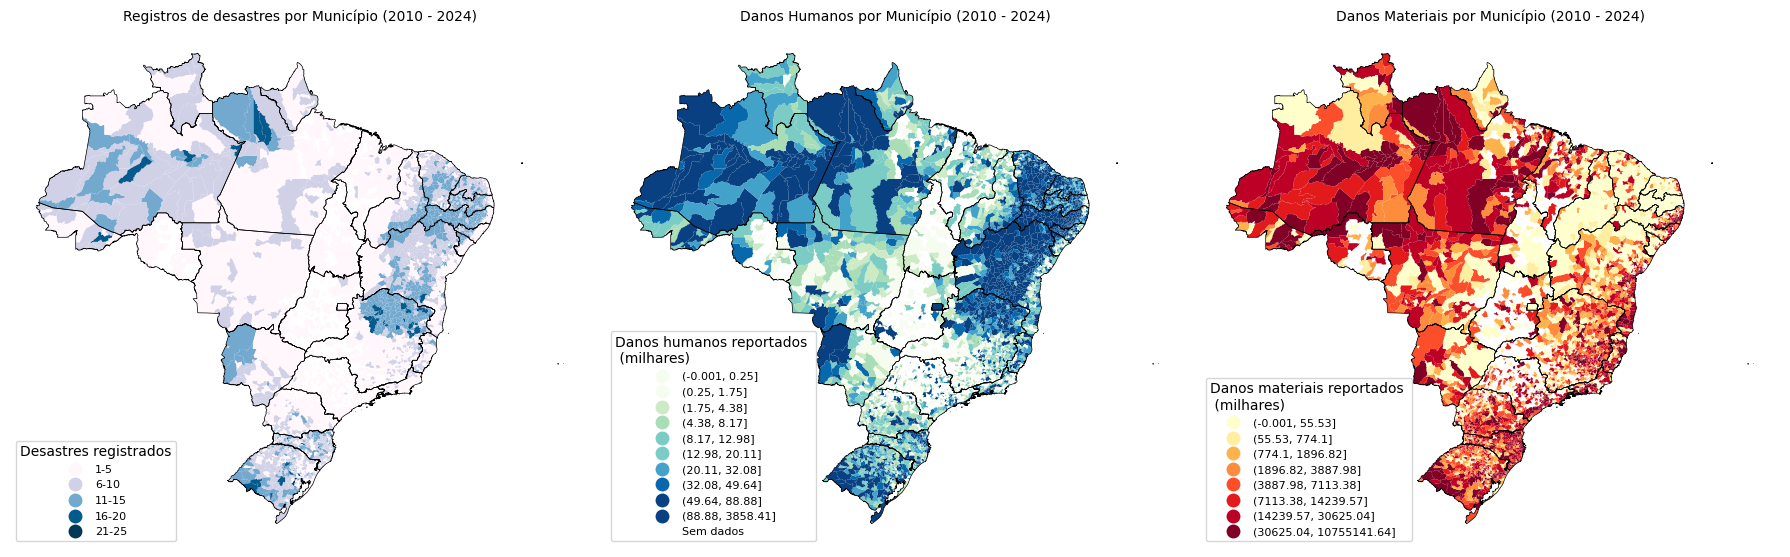

In [107]:
# Paleta de cores
colors_materiais = ["#FFFFCC", "#FFEDA0", "#FEB24C", "#FD8D3C", "#FC4E2A", "#E31A1C", "#BD0026", "#800026"]
colors_humanos = ["#f7fcf0", "#ccebc5", "#a8ddb5", "#7bccc4", "#43a2ca", "#0868ac", "#084081"]
colors_s2id = ["#FFF7FB", "#ECE2F0", "#D0D1E6", "#A6BDDB", "#74A9CF", "#2B8CBE", "#045A8D", "#023858"]

# Criar uma figura com três subplots lado a lado (1 linha, 3 colunas)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Registro de desastres
bins = [0, 5, 10, 15, 20, 25]
labels = ['1-5', '6-10', '11-15', '16-20', '21-25']
df_eventos_analise['S2id_binned'] = pd.cut(df_eventos_analise['S2id_count'], bins=bins, labels=labels, include_lowest=True)
cmap_s2id = mcolors.ListedColormap(colors_s2id)
df_eventos_analise.plot(ax=axes[0], column='S2id_binned', cmap=cmap_s2id, legend=True, legend_kwds={
    'title': "Desastres registrados",
    'loc': 'lower left',
    'fontsize': 8
})
estados_geo.boundary.plot(ax=axes[0], linewidth=0.5, edgecolor='black')
axes[0].set_title("Registros de desastres por Município (2010 - 2024)", fontsize=10)
axes[0].axis("off")

# Danos humanos
df_eventos_analise['DH_total_danos_humanos_milhares'] = (df_eventos_analise['DH_total_danos_humanos'] / 1000).round(2)
df_eventos_analise['DH_total_danos_humanos_milhares'] = df_eventos_analise['DH_total_danos_humanos_milhares'].fillna(float('nan'))
df_eventos_analise['DH_total_danos_humanos_milhares'] = df_eventos_analise['DH_total_danos_humanos_milhares'].clip(lower=0)
decis_danos_humanos = pd.qcut(df_eventos_analise['DH_total_danos_humanos_milhares'], q=10, duplicates='drop')
df_eventos_analise['Danos_Humanos_Decis'] = decis_danos_humanos
cmap_humanos = mcolors.ListedColormap(colors_humanos)
df_eventos_analise.plot(ax=axes[1], column='Danos_Humanos_Decis', cmap=cmap_humanos, legend=True, 
                        missing_kwds={"color": "white", "label": "Sem dados"}, legend_kwds={
    'title': "Danos humanos reportados \n (milhares)",
    'loc': 'lower left',
    'fontsize': 8
})
estados_geo.boundary.plot(ax=axes[1], linewidth=0.5, edgecolor='black')
axes[1].set_title("Danos Humanos por Município (2010 - 2024)", fontsize=10)
axes[1].axis("off")

# Danos materiais
df_eventos_analise['DM_total_danos_materiais_milhares'] = (df_eventos_analise['DM_total_danos_materiais'] / 1000).round(2)
decis_danos_materiais = pd.qcut(df_eventos_analise['DM_total_danos_materiais_milhares'], q=10, duplicates='drop')
df_eventos_analise['Danos_Materiais_Decis'] = decis_danos_materiais
cmap_materiais = mcolors.ListedColormap(colors_materiais)
df_eventos_analise.plot(ax=axes[2], column='Danos_Materiais_Decis', cmap=cmap_materiais, legend=True, legend_kwds={
    'title': "Danos materiais reportados \n (milhares)",
    'loc': 'lower left',
    'fontsize': 8
})
estados_geo.boundary.plot(ax=axes[2], linewidth=0.5, edgecolor='black')
axes[2].set_title("Danos Materiais por Município (2010 - 2024)", fontsize=10)
axes[2].axis("off")

# Mapas lado a lado
plt.tight_layout()

plt.show()

### Dados ausentes em relação à renda do município
Foi levantada a preocupação pelo grupo de que municípios de menor capacidade econômica poderiam ter mais dificuldade em acessar o sistema e preencher todas as informações solicitadas. Por esse motivo, foi realizada análise sobre o perfil econômico dos municípios que não preencheram todas as informações.

A análise a seguir considera as relação da ausência de informação nas variáveis DA_Polui/con do ar; DA_Polui/cont do solo; DA_Polui/cont da água; DA_Incênd parques APA's/APP's; DA_Dimi/exauri hídrico; DM_Descricao; DA_Descricao; PEPL_Descricao; PEPR_Descricao; DH_Descricao e o PIB do município.

In [ ]:
colunas = [
    'DA_Polui/cont do ar',
    'DA_Polui/cont do solo',
    'DA_Polui/cont da água',
    "DA_Incêndi parques/APA's/APP's",
    'DA_Dimi/exauri hídrico',
    'DM_Descricao',
    'DA_Descricao',
    'PEPL_Descricao',
    'PEPR_Descricao',
    'DH_Descricao'
]

df_eventos_missing = df_eventos.copy()

df_eventos_missing = df_eventos_missing.dropna(subset=['PIB'])
#Existem dados para o PIB apenas até 2021.

df_eventos_missing['Total_Missing'] = df_eventos_missing[colunas].isnull().sum(axis=1)
df_eventos_missing['PIB_per_capita'] = df_eventos_missing['PIB'] / df_eventos_missing['Pop']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PIB_per_capita', y='Total_Missing', data=df_eventos_missing, hue='Status', palette='deep')
plt.title('Relação entre renda per capita e dados ausentes')
plt.xlabel('PIB per capita')
plt.ylabel('Total de Valores Ausentes')
plt.show()


In [ ]:
correlation = df_eventos_missing['PIB_per_capita'].corr(df_eventos_missing['Total_Missing'])
print(f"\nCorrelação entre renda per capita e total de valores ausentes: {correlation:.2f}")

Correlação baixa entre os valores ausentes nas variáveis DA_Polui/con do ar; DA_Polui/cont do solo; DA_Polui/cont da água; DA_Incênd parques APA's/APP's; DA_Dimi/exauri hídrico; DM_Descricao; DA_Descricao; PEPL_Descricao; PEPR_Descricao; DH_Descricao e a renda per capita do município.

### PIB x Status

In [ ]:
df_eventos_apos2022 = df_eventos.copy()
df_eventos_apos2022 = df_eventos_apos2022.dropna(subset=['PIB'])
#Existem dados para o PIB apenas até 2022.
status_counts = df_eventos['Status'].value_counts()

df_eventos_apos2022['PIB_per_capita'] = df_eventos_apos2022['PIB'] / df_eventos_apos2022['Pop']

plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='PIB_per_capita', data=df_eventos_apos2022, palette='deep', order=status_counts.index)
plt.title('Distribuição da renda per capita por status de reconhecimento')
plt.xlabel('Status')
plt.ylabel('Renda per capita')
plt.xticks(rotation=0)
plt.show()

Grande quantidade de outliers tanto nos protocolos reconhecimentos como estado de calamidade pública ou situação de emergência.

In [ ]:
#Eliminando-se os outliers abaixo de 1% e acima de 99% para enxergar melhor a distribuição

q1 = df_eventos_apos2022['PIB_per_capita'].quantile(0.01)
q99 = df_eventos_apos2022['PIB_per_capita'].quantile(0.99)

df_eventos_filtrado = df_eventos_apos2022[(df_eventos_apos2022['PIB_per_capita'] >= q1) & (df_eventos_apos2022['PIB_per_capita'] <= q99)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='PIB_per_capita', data=df_eventos_filtrado, palette='deep', order=status_counts.index)
plt.title('Distribuição da renda per capita (sem outliers) por status de reconhecimento')
plt.xlabel('Status')
plt.ylabel('Renda per capita')
plt.xticks(rotation=0)
plt.show()

Na classe de eventos que não receberam reconhecimento federal, a distribuição da renda per capita tem maior mediana.